# Use RBM to sample from mnist 

In [433]:
import jax 
from jax import numpy as jnp
from jax import jit 
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
from skimage.transform import resize 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [444]:
data = mnist.data.values / 255
P = 2000
X = resize(data[:P, :].reshape(P, 28, 28), (P, 16, 16), anti_aliasing=True).reshape(P, 16*16)


In [446]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [447]:
def break_covariances(data): 
    data = pd.DataFrame(data).apply(lambda row: pd.Series(np.random.permutation(row.values), index=row.index), axis=1).values
    return data 

In [448]:
X_scaled_shuffled = break_covariances(X_scaled.T).T 

In [473]:
class GenerativeRBM(BernoulliRBM): 
    def __init__(self, key, data, n_components, random_state ): 
        super().__init__(n_components=n_components, random_state=random_state)
        self.key = key 
        self.data = data
        self.burnin = 0 
        self.tau = 1
        self.set_empirical_means()
        self.learning_rate=0.1
        self.n_iter=100

    def train(self): 
        self.fit(self.data.T) # data is N rows (N features) by P columns (P samples) (physics convention) 

    def sample(self, num_samples, v_init=None):
        iters = self.burnin + self.tau * num_samples
        generated_data = np.zeros((len(self.data), iters))
        if v_init is None: 
            v_init = np.array(jax.random.bernoulli(self.key, shape=(len(generated_data), ))) 
        v = v_init 
        for i in range(iters):
            v = self.gibbs(v)
            generated_data[:, i] = v 
        return generated_data[:, self.burnin::self.tau]
    
    @staticmethod
    def compute_averages(samples): 
        return jnp.mean(samples, axis=1), jnp.cov(samples)

    def set_empirical_means(self): 
        self.mean, self.cov = self.compute_averages(self.data) 

    def compute_squared_deviations(self, samples): 
        sample_mean, cov = self.compute_averages(samples)
        return (sample_mean - self.mean)**2, (cov - self.cov)**2
    
    def split_data_in_half(self): 
        cols = self.data.shape[1]
        perm = jax.random.permutation(self.key, cols)
        fh_indices = perm[:cols // 2]
        sh_indices = perm[-cols//2:]
        first_half_data = self.data[:, fh_indices]
        second_half_data = self.data[:, sh_indices]
        return first_half_data, second_half_data 

    def background_model_squared_deviations(self): 
        first_half_data, second_half_data = self.split_data_in_half()
        fhm, fhc = self.compute_averages(first_half_data)
        shm, shc = self.compute_averages(second_half_data)
        return (fhm - shm)**2, (fhc - shc)**2
    
    def compute_background_rmse(self):
        mean_diffs, cov_diffs = self.background_model_squared_deviations() 
        return jnp.sqrt(jnp.mean(mean_diffs)), jnp.sqrt(jnp.mean(cov_diffs.flatten()))

    def compute_rmse(self, samples): 
        mean_devs, cov_devs = self.compute_squared_deviations(samples)
        return jnp.sqrt(jnp.mean(mean_devs)), jnp.sqrt(jnp.mean(cov_devs.flatten()))
    
    def compute_deviations_over_training(self, training_intervals=None): 
        if training_intervals is None: 
            training_intervals = np.arange(100, 600, 100)
        
        means, covs = [], []
        
        for ti in training_intervals: 
            self.n_iter = ti 
            self.train()
            samples = self.sample(num_samples=self.data.shape[1])
            m, c = self.compute_rmse(samples) 
            means.append(m) 
            covs.append(c) 
        
        return means, covs 
    
    def plot_deviations_over_training(self, training_intervals=None): 
        
        if training_intervals is None: 
            training_intervals = np.arange(100, 600, 100)
        
        m, c = self.compute_deviations_over_training(training_intervals)
        fig, ax = plt.subplots()
        ax.scatter(training_intervals, m, label='rmse in means (samples vs data)')
        ax.scatter(training_intervals, c, label='rmse in covs (samples vs data)') 
        ax.plot(training_intervals, m)
        ax.plot(training_intervals, c) 
        bm, bc = self.compute_background_rmse()
        ax.hlines(bm, min(training_intervals), max(training_intervals), ls='--', label='rmse in means (data vs data)')
        ax.hlines(bc, min(training_intervals), max(training_intervals), ls='--', color='tab:orange', label='rmse in covs (data vs data)')
        ax.legend() 
        ax.set_xlabel('training iterations') 
        ax.set_ylabel('rmse') 
        ax.set_yscale('log') 
        fig.suptitle(r'training rbm; n={n}, $\gamma={lr}$'.format(n=self.n_components, lr=self.learning_rate))
        fig.savefig('tmp.png')

        return fig, ax, m, c 

In [502]:
key = jax.random.PRNGKey(0) 
rbm = GenerativeRBM(key, data=X_scaled.T > 0.5, n_components=256, random_state=0)
rbm.tau = 10
rbm.learning_rate = .0001

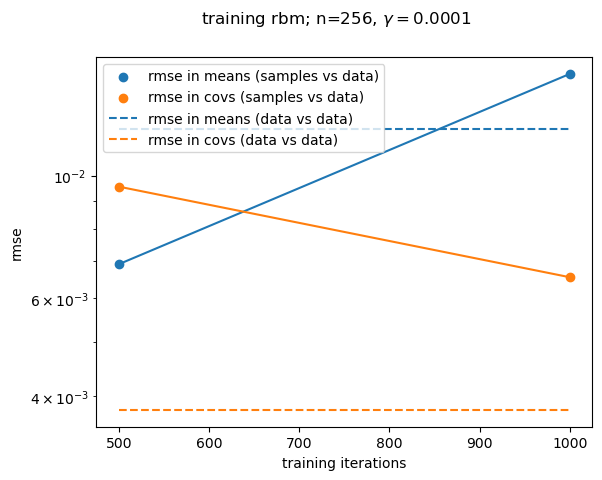

In [503]:
training_steps = [500, 1000]
fig, ax, m, c = rbm.plot_deviations_over_training(training_steps)

In [481]:
samples = rbm.sample(10) 

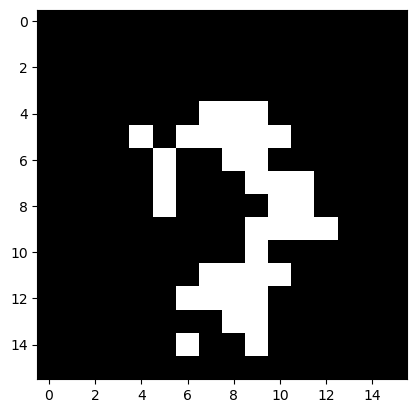

In [491]:
plt.imshow(samples[:, 4].reshape(16, 16), cmap='grey')